# January flight prediction beginner

In [37]:
# IMPORTING LIBRARIES
# to run the program in jupyter notebook shortcut key : Shift+Enter

import pandas as pd   # mostly we will deal with 'cvs' file type.

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize) :
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    return plot_importance(booster = booster, ax = ax)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import time
import sys
import gc
import pickle

sys.version_info


sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

# LOADING DATASET

In [38]:
jan_2019_ontime = pd.read_csv("D:\\Data Science\\Dataset\\599747_1080724_bundle_archive\\Jan_2019_ontime.csv")
jan_2020_ontime = pd.read_csv("D:\\Data Science\\Dataset\\599747_1080724_bundle_archive\\Jan_2020_ontime.csv")


In [39]:
jan_2019_ontime.tail()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
583980,31,4,UA,19977,UA,N776UA,200,12016,1201602,GUM,12173,1217305,HNL,749.0,0.0,0700-0759,1832.0,0.0,0.0,0.0,3801.0,NaN
583981,31,4,UA,19977,UA,N36280,174,12016,1201602,GUM,14955,1495503,SPN,717.0,0.0,0700-0759,759.0,0.0,0.0,0.0,129.0,NaN
583982,31,4,UA,19977,UA,N36280,117,14955,1495503,SPN,12016,1201602,GUM,857.0,0.0,0900-0959,933.0,0.0,0.0,0.0,129.0,NaN
583983,31,4,UA,19977,UA,N39726,105,14955,1495503,SPN,12016,1201602,GUM,1820.0,0.0,1800-1859,1854.0,0.0,0.0,0.0,129.0,NaN
583984,31,4,UA,19977,UA,N39726,104,12016,1201602,GUM,14955,1495503,SPN,1636.0,0.0,1600-1659,1719.0,0.0,0.0,0.0,129.0,NaN


In [40]:
#DEP_TIME_BLK contains an invalid label 
#fix it to 0500-0559

jan_2019_ontime.loc[jan_2019_ontime['DEP_TIME_BLK'] == '0001-0559' , 'DEP_TIME_BLK' ] = '0500-0559'

# DATA VISUALISATION

In [41]:
#comparing arrivals and departures time frames

values = [jan_2019_ontime['DEP_DEL15'].value_counts()[0], jan_2019_ontime['DEP_DEL15'].value_counts()[1]]
labels = ["Delayed (<15 minutes)", "Delayed (>15 minutes)"]
colors = ['blue', 'red']
values_arrival = [jan_2019_ontime['ARR_DEL15'].value_counts()[0], jan_2019_ontime['ARR_DEL15'].value_counts()[0]]


fig = make_subplots(1, 2, specs=[[{'type' : 'domain'}, {'type' : 'domain'}]], subplot_titles=['Departures', 'Arrivals'])

fig.add_trace(go.Pie(labels=labels, values=values, pull=[0, 0.1],textinfo = 'label+percent'),1,1)
fig.add_trace(go.Pie(labels=labels, values=values_arrival, pull=[0, 0.1],textinfo = 'label+percent'),1,2)

fig.update_traces( textinfo='value', textfont_size=14,marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', title_text='Flights Delayed', title_x = 0.5, legend_title='<b>               Flights</b>',legend=dict(x=.45, y=0.6))

fig.show()

Text(0, 0.5, 'Arrival delay (in minutes)')

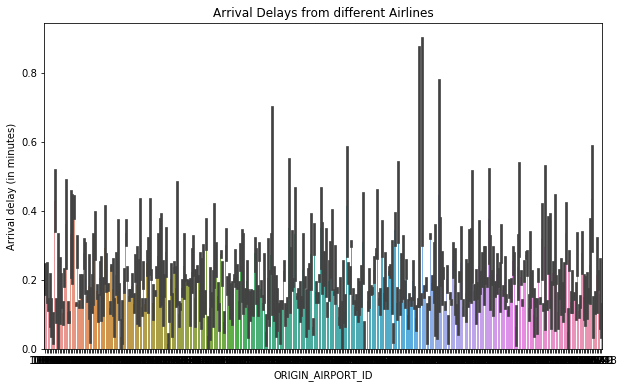

In [13]:
#Barplot
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Arrival Delays from different Airlines")
# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=jan_2019_ontime.ORIGIN_AIRPORT_ID, y=jan_2019_ontime['ARR_DEL15'])
# Add label for vertical axis
plt.ylabel("Arrival delay (in minutes)")

Text(0, 0.5, 'Arrival delay (in minutes)')

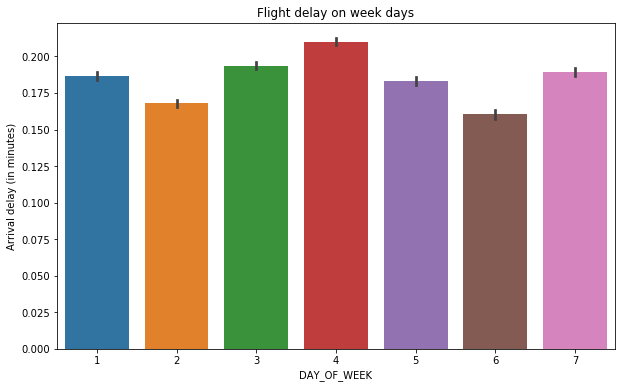

In [14]:
#Barplot
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Flight delay on week days")
# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=jan_2019_ontime.DAY_OF_WEEK, y=jan_2019_ontime['ARR_DEL15'])
# Add label for vertical axis
plt.ylabel("Arrival delay (in minutes)")

# DEALING WITH MISSING VALUES

In [18]:
#drop flights with missing data
jan_2019_ontime = jan_2019_ontime[ (jan_2019_ontime.CANCELLED != 1) & (jan_2019_ontime.DEP_TIME.isna() == False) & (jan_2019_ontime.ARR_TIME.isna() == False)]
len(jan_2019_ontime.CANCELLED.isna()), len(jan_2019_ontime.DEP_TIME.isna()), len(jan_2019_ontime.ARR_TIME.isna()), len(jan_2019_ontime)

# drop when target is NAN
jan_2019_ontime = jan_2019_ontime[ (jan_2019_ontime.ARR_DEL15.isna() == False)]

# DROPING UNNECESSARY COLUMNS

In [19]:
cols=['Unnamed: 21','OP_CARRIER_AIRLINE_ID','OP_CARRIER','DIVERTED','CANCELLED','ORIGIN','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_SEQ_ID','DEST','DAY_OF_MONTH','OP_UNIQUE_CARRIER']
jan_2019_ontime=jan_2019_ontime.drop(cols,axis=1)

# CONVERTING DATA VALUES INTO MORE USEFUL FORM

In [20]:
def get_day_category(day_of_week):
    if day_of_week <= 5:
        return 0 #'for working day'
    elif day_of_week > 5:
        return 1 #'for weekend'
    
jan_2019_ontime.DAY_OF_WEEK = jan_2019_ontime.DAY_OF_WEEK.apply(get_day_category)
jan_2019_ontime.rename(columns={'DAY_OF_WEEK':'type_of_day'})

,type_of_day,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
0,0,11953,10397,601.0,0.0,0600-0659,722.0,0.0,300.0
1,0,13487,11193,1359.0,0.0,1400-1459,1633.0,0.0,596.0
2,0,11433,11193,1215.0,0.0,1200-1259,1329.0,0.0,229.0
3,0,15249,10397,1521.0,0.0,1500-1559,1625.0,0.0,223.0
4,0,10397,11778,1847.0,0.0,1900-1959,1940.0,0.0,579.0
...,...,...,...,...,...,...,...,...,...
583980,0,12016,12173,749.0,0.0,0700-0759,1832.0,0.0,3801.0
583981,0,12016,14955,717.0,0.0,0700-0759,759.0,0.0,129.0
583982,0,14955,12016,857.0,0.0,0900-0959,933.0,0.0,129.0
583983,0,14955,12016,1820.0,0.0,1800-1859,1854.0,0.0,129.0


In [21]:
jan_2019_ontime['origin_day_avg'] = jan_2019_ontime.groupby(['ORIGIN_AIRPORT_ID','DAY_OF_WEEK'])['DEP_TIME'].transform('mean').astype(np.float16)
jan_2019_ontime['dest_day_avg'] = jan_2019_ontime.groupby(['DEST_AIRPORT_ID','DAY_OF_WEEK'])['ARR_TIME'].transform('mean').astype(np.float16)

In [22]:
#replace missing target values 
def new_arrival_delay(dep_delay, arr_delay):
    if np.isnan(arr_delay):
        return dep_delay
    else:
        return arr_delay

jan_2019_ontime['ARR_DEL15'] = jan_2019_ontime.apply(lambda row :new_arrival_delay(row['DEP_DEL15'],row['ARR_DEL15']), axis = 1)

In [23]:
# CREATE ARR_TIME_BLK 

#generate block hours
blocks = []
for hour in range(0,24):
    hour_part = ('%02d' %(hour))
    blocks.append(hour_part + '00-' + hour_part + '59')
blocks

def arrival_time_blk(arr_time):
    arr_hour = str('%04d' %(arr_time))[:2]
    arr_block = None
    for block in blocks:
        #print (block,arr_hour)
        if block.startswith(arr_hour):
            arr_block = block
            break
    if arr_block == None and str(arr_time) == '2400.0':
        arr_block = '0000-0059'
        #print('Cannot find block for #' + str(arr_time) + '#: set block to #' + arr_block + '#')
    return arr_block

jan_2019_ontime['ARR_TIME_BLK'] = jan_2019_ontime.ARR_TIME.apply(arrival_time_blk)
# drop the no more useful ARR_TIME
jan_2019_ontime.drop(['ARR_TIME'], inplace=True, axis=1)

# LABEL ENCODING OF CATEGORICAL DATA COLUMNS

In [25]:
# label encode ARR_TIME_BLK and DEP_TIME_BLK
le = LabelEncoder()
le.fit(blocks)
le.classes_
jan_2019_ontime['ARR_TIME_BLK'] = le.transform(jan_2019_ontime.ARR_TIME_BLK.values)
jan_2019_ontime['DEP_TIME_BLK'] = le.transform(jan_2019_ontime.DEP_TIME_BLK.values)

In [27]:
#Before spliting data, SORT IT FIRST
jan_2019_ontime= jan_2019_ontime.reindex(sorted(jan_2019_ontime.columns), axis=1)

In [28]:
jan_2019_ontime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565963 entries, 0 to 583984
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ARR_DEL15          565963 non-null  float64
 1   ARR_TIME_BLK       565963 non-null  int32  
 2   DAY_OF_WEEK        565963 non-null  int64  
 3   DEP_DEL15          565963 non-null  float64
 4   DEP_TIME           565963 non-null  float64
 5   DEP_TIME_BLK       565963 non-null  int32  
 6   DEST_AIRPORT_ID    565963 non-null  int64  
 7   DISTANCE           565963 non-null  float64
 8   ORIGIN_AIRPORT_ID  565963 non-null  int64  
 9   dest_day_avg       565963 non-null  float16
 10  origin_day_avg     565963 non-null  float16
dtypes: float16(2), float64(4), int32(2), int64(3)
memory usage: 41.0 MB


In [29]:
#Remove DEP_TIME column 
jan_2019_ontime= jan_2019_ontime.drop(['DEP_TIME','DEP_DEL15'], axis=1)

In [31]:
jan_2019_ontime.head()

,ARR_DEL15,ARR_TIME_BLK,DAY_OF_WEEK,DEP_TIME_BLK,DEST_AIRPORT_ID,DISTANCE,ORIGIN_AIRPORT_ID,dest_day_avg,origin_day_avg
0,0.0,7,0,6,10397,300.0,11953,1421.0,1199.0
1,0.0,16,0,14,11193,596.0,13487,1529.0,1384.0
2,0.0,13,0,12,11193,229.0,11433,1529.0,1399.0
3,0.0,16,0,15,10397,223.0,15249,1421.0,1195.0
4,0.0,19,0,19,11778,579.0,10397,1620.0,1464.0


# SPILT DATA FOR TRAINING AND TESTING

In [32]:
from sklearn.model_selection import train_test_split
Y = jan_2019_ontime['ARR_DEL15'].values
X = jan_2019_ontime.drop(['ARR_DEL15'], axis=1).values

X_train, X_valid, Y_train, Y_valid =  train_test_split(X,Y, test_size=0.2, random_state=1)

# MODEL TRAINING WITH XGBOOST

In [33]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="auc", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[20:04:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-auc:0.665699	validation_1-auc:0.666917
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.765274	validation_1-auc:0.763935
[2]	validation_0-auc:0.760878	validation_1-auc:0.759484
[3]	validation_0-auc:0.787884	validation_1-auc:0.786028
[4]	validation_0-auc:0.798056	validation_1-auc:0.796257
[5]	validation_0-auc:0.797747	validation_1-auc:0.796083
[6]	validation_0-auc:0.803433	validation_1-auc:0.80135
[7]	validation_0-auc:0.803909	validation_1-auc:0.801711
[8]	validation_0-auc:0.809472	validation_1-auc:0.807088
[9]	validation_0-auc:0.813223	validation_1-auc:0.810702
[10]	validation_0-auc:0.814733	validation_1-auc:0.812187
[11]	validation_0-auc:0.816699	validation_1-auc:0.813927
[12]	v

[139]	validation_0-auc:0.883246	validation_1-auc:0.872925
[140]	validation_0-auc:0.883656	validation_1-auc:0.873271
[141]	validation_0-auc:0.883715	validation_1-auc:0.8733
[142]	validation_0-auc:0.883964	validation_1-auc:0.873547
[143]	validation_0-auc:0.884215	validation_1-auc:0.873748
[144]	validation_0-auc:0.884275	validation_1-auc:0.87377
[145]	validation_0-auc:0.884675	validation_1-auc:0.874157
[146]	validation_0-auc:0.884805	validation_1-auc:0.874284
[147]	validation_0-auc:0.885067	validation_1-auc:0.874498
[148]	validation_0-auc:0.885123	validation_1-auc:0.874545
[149]	validation_0-auc:0.88522	validation_1-auc:0.874602
[150]	validation_0-auc:0.885516	validation_1-auc:0.874835
[151]	validation_0-auc:0.885609	validation_1-auc:0.874899
[152]	validation_0-auc:0.885814	validation_1-auc:0.87506
[153]	validation_0-auc:0.886054	validation_1-auc:0.87527
[154]	validation_0-auc:0.886327	validation_1-auc:0.875509
[155]	validation_0-auc:0.886476	validation_1-auc:0.875655
[156]	validation_0-a

[281]	validation_0-auc:0.90077	validation_1-auc:0.887209
[282]	validation_0-auc:0.900868	validation_1-auc:0.887309
[283]	validation_0-auc:0.900939	validation_1-auc:0.88736
[284]	validation_0-auc:0.901021	validation_1-auc:0.887421
[285]	validation_0-auc:0.901121	validation_1-auc:0.887485
[286]	validation_0-auc:0.901152	validation_1-auc:0.887512
[287]	validation_0-auc:0.901234	validation_1-auc:0.887575
[288]	validation_0-auc:0.90125	validation_1-auc:0.887569
[289]	validation_0-auc:0.901298	validation_1-auc:0.887609
[290]	validation_0-auc:0.901394	validation_1-auc:0.887682
[291]	validation_0-auc:0.901408	validation_1-auc:0.887705
[292]	validation_0-auc:0.901501	validation_1-auc:0.887768
[293]	validation_0-auc:0.901636	validation_1-auc:0.887866
[294]	validation_0-auc:0.901719	validation_1-auc:0.887941
[295]	validation_0-auc:0.901781	validation_1-auc:0.888022
[296]	validation_0-auc:0.901884	validation_1-auc:0.888095
[297]	validation_0-auc:0.901983	validation_1-auc:0.888147
[298]	validation_

[423]	validation_0-auc:0.909076	validation_1-auc:0.893414
[424]	validation_0-auc:0.909152	validation_1-auc:0.893464
[425]	validation_0-auc:0.909197	validation_1-auc:0.89351
[426]	validation_0-auc:0.909259	validation_1-auc:0.893557
[427]	validation_0-auc:0.909319	validation_1-auc:0.893603
[428]	validation_0-auc:0.909332	validation_1-auc:0.893619
[429]	validation_0-auc:0.909365	validation_1-auc:0.893628
[430]	validation_0-auc:0.909424	validation_1-auc:0.89366
[431]	validation_0-auc:0.909463	validation_1-auc:0.893692
[432]	validation_0-auc:0.909506	validation_1-auc:0.89373
[433]	validation_0-auc:0.909548	validation_1-auc:0.893766
[434]	validation_0-auc:0.909629	validation_1-auc:0.893827
[435]	validation_0-auc:0.909662	validation_1-auc:0.893851
[436]	validation_0-auc:0.909742	validation_1-auc:0.893911
[437]	validation_0-auc:0.909786	validation_1-auc:0.893946
[438]	validation_0-auc:0.90983	validation_1-auc:0.893984
[439]	validation_0-auc:0.909887	validation_1-auc:0.894025
[440]	validation_0

[565]	validation_0-auc:0.914577	validation_1-auc:0.897308
[566]	validation_0-auc:0.914613	validation_1-auc:0.897331
[567]	validation_0-auc:0.91463	validation_1-auc:0.897339
[568]	validation_0-auc:0.914659	validation_1-auc:0.897362
[569]	validation_0-auc:0.914663	validation_1-auc:0.897367
[570]	validation_0-auc:0.914685	validation_1-auc:0.897373
[571]	validation_0-auc:0.914723	validation_1-auc:0.897402
[572]	validation_0-auc:0.914756	validation_1-auc:0.897401
[573]	validation_0-auc:0.914785	validation_1-auc:0.897418
[574]	validation_0-auc:0.91479	validation_1-auc:0.897423
[575]	validation_0-auc:0.914861	validation_1-auc:0.897489
[576]	validation_0-auc:0.914873	validation_1-auc:0.897497
[577]	validation_0-auc:0.91492	validation_1-auc:0.897537
[578]	validation_0-auc:0.914978	validation_1-auc:0.89757
[579]	validation_0-auc:0.915007	validation_1-auc:0.897579
[580]	validation_0-auc:0.91504	validation_1-auc:0.897605
[581]	validation_0-auc:0.915078	validation_1-auc:0.897627
[582]	validation_0-

[707]	validation_0-auc:0.918128	validation_1-auc:0.899721
[708]	validation_0-auc:0.918141	validation_1-auc:0.89973
[709]	validation_0-auc:0.918156	validation_1-auc:0.899748
[710]	validation_0-auc:0.918176	validation_1-auc:0.899749
[711]	validation_0-auc:0.918176	validation_1-auc:0.899746
[712]	validation_0-auc:0.918213	validation_1-auc:0.89976
[713]	validation_0-auc:0.918256	validation_1-auc:0.899782
[714]	validation_0-auc:0.918275	validation_1-auc:0.899804
[715]	validation_0-auc:0.918294	validation_1-auc:0.899818
[716]	validation_0-auc:0.91831	validation_1-auc:0.899837
[717]	validation_0-auc:0.918317	validation_1-auc:0.899833
[718]	validation_0-auc:0.918354	validation_1-auc:0.899854
[719]	validation_0-auc:0.918366	validation_1-auc:0.899868
[720]	validation_0-auc:0.91838	validation_1-auc:0.899883
[721]	validation_0-auc:0.918396	validation_1-auc:0.899893
[722]	validation_0-auc:0.918402	validation_1-auc:0.899892
[723]	validation_0-auc:0.918416	validation_1-auc:0.899887
[724]	validation_0

[849]	validation_0-auc:0.920945	validation_1-auc:0.901508
[850]	validation_0-auc:0.920978	validation_1-auc:0.901519
[851]	validation_0-auc:0.921015	validation_1-auc:0.901549
[852]	validation_0-auc:0.921025	validation_1-auc:0.901559
[853]	validation_0-auc:0.921037	validation_1-auc:0.901568
[854]	validation_0-auc:0.921041	validation_1-auc:0.90157
[855]	validation_0-auc:0.921052	validation_1-auc:0.901572
[856]	validation_0-auc:0.921083	validation_1-auc:0.901592
[857]	validation_0-auc:0.921101	validation_1-auc:0.901606
[858]	validation_0-auc:0.921118	validation_1-auc:0.901615
[859]	validation_0-auc:0.92114	validation_1-auc:0.901618
[860]	validation_0-auc:0.921158	validation_1-auc:0.901625
[861]	validation_0-auc:0.92118	validation_1-auc:0.901641
[862]	validation_0-auc:0.921205	validation_1-auc:0.901658
[863]	validation_0-auc:0.921226	validation_1-auc:0.901667
[864]	validation_0-auc:0.921215	validation_1-auc:0.901657
[865]	validation_0-auc:0.921236	validation_1-auc:0.901681
[866]	validation_

[991]	validation_0-auc:0.923332	validation_1-auc:0.90287
[992]	validation_0-auc:0.923337	validation_1-auc:0.902876
[993]	validation_0-auc:0.923344	validation_1-auc:0.902879
[994]	validation_0-auc:0.923352	validation_1-auc:0.902889
[995]	validation_0-auc:0.923358	validation_1-auc:0.902892
[996]	validation_0-auc:0.923362	validation_1-auc:0.902888
[997]	validation_0-auc:0.923375	validation_1-auc:0.902902
[998]	validation_0-auc:0.923388	validation_1-auc:0.902905
[999]	validation_0-auc:0.923421	validation_1-auc:0.902917


1586.202053785324

In [34]:
Y_preds=model.predict(X_valid)

# FEATURE IMPORTANCE

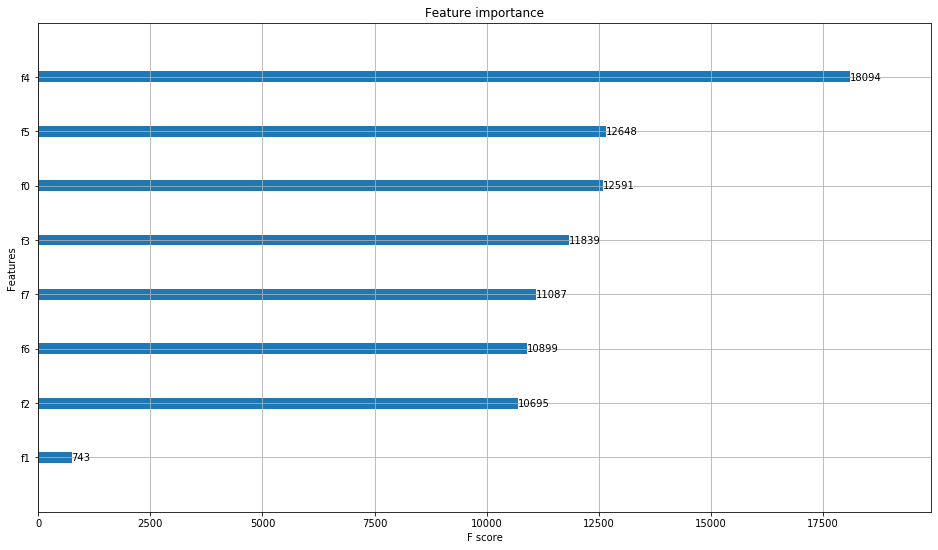

In [35]:
plot_features(model,(16,9))